In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install mido
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 7.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 20.3 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=73207009f85981344230bbf96c79988361879cbeab6843e40301ecdf0bcdf1b1
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi


In [4]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import mido
import pretty_midi
import os
import random
from torch.utils.data import Dataset, DataLoader
from utils import get_filenames, generate_roll
from const import BATCH_SIZE

In [5]:
!unzip -u "/content/drive/MyDrive/MuseNator/midis_v1.2.zip"

Streaming output truncated to the last 5000 lines.
  inflating: midis/Masotti, Celestina, Angel Dreams, Op.41, 3K-4kAOSSg4.mid  
  inflating: midis/German, Edward, Rêverie, 8P9mSttI3ZY.mid  
  inflating: midis/Roslavets, Nikolay, 5 Preludes, qJlxl8Dpbp0.mid  
  inflating: midis/Rochard, Jules, Love's Young Dream, ZtXg0peDu64.mid  
  inflating: midis/Varley, Irene, Capricietta, nVo5MHtR9aM.mid  
  inflating: midis/Levy, Sol Paul, Lovelette, PYM_13FKgGg.mid  
  inflating: midis/Merino Martínez, Aitor, Neuronas, X1RVIo4MyYo.mid  
  inflating: midis/Scharwenka, Philipp, Hochzeitsmusik, Op.23, 1t0hlc5_KE4.mid  
  inflating: midis/Agnew, Roy, Poem No.1, GHWFSi_4Ltg.mid  
  inflating: midis/Arévalo, Miguel Santiago, La Súplica, zM1SenJ9gqc.mid  
  inflating: midis/Hässler, Johann Wilhelm, Fantaisie et Sonate, Op.3, Cd18FtIFB7c.mid  
  inflating: midis/Hindemith, Paul, Sonata for 2 Pianos, zpHZkiZHOSM.mid  
  inflating: midis/Smallwood, William, Summer on the Lake, JcAmWt_2WiQ.mid  
  inflatin

### Preprocessing

In [6]:
filenames = get_filenames('/content/midis')
print(len(filenames))
train_filenames = filenames[:int(len(filenames) * 0.9)]
test_filenames = filenames[(len(train_filenames)):]

10855


In [29]:
train_loader = DataLoader(train_filenames, batch_size = 256, collate_fn=generate_roll)
test_loader = DataLoader(test_filenames, batch_size = 256, collate_fn=generate_roll)

### Model

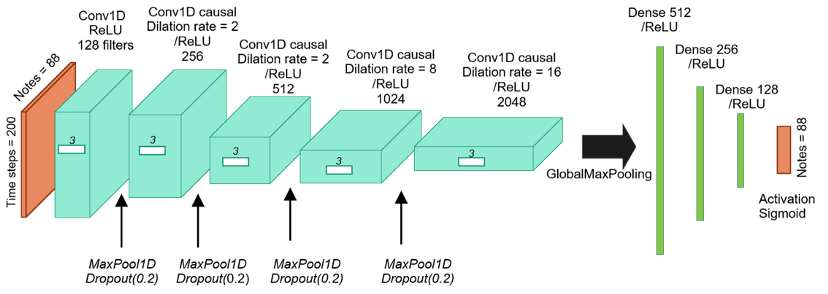

The following architecture was adopted from TensorFlow implementation of Phillip Petit, Gatien Vassor, Emna Bairam and Wladimir Raymond: https://towardsdatascience.com/pyzzicato-piano-instrumental-music-generation-using-deep-neural-networks-ed9e89320bf6

Speaking short, this is a pseudo-WaveNet architecture, having five convolution blocks and one linear block. We did not want to use Tensorflow, therefore we implemented this architecture using PyTorch.

In [31]:
n_notes = 88
len_feats = 1000 #temp value

class CausalConv1d(torch.nn.Conv1d):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 dilation=1,
                 groups=1,
                 bias=True):

        super(CausalConv1d, self).__init__(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=0,
            dilation=dilation,
            groups=groups,
            bias=bias)
        
        self.__padding = (kernel_size - 1) * dilation
        
    def forward(self, input):
        return super(CausalConv1d, self).forward(F.pad(input, (self.__padding, 0)))


class GlobalMaxPooling1D(nn.Module):

    def __init__(self, data_format='channels_first'):
        super(GlobalMaxPooling1D, self).__init__()
        self.data_format = data_format
        self.step_axis = 1 if self.data_format == 'channels_last' else 2

    def forward(self, input):
        return torch.max(input.unsqueeze(0), axis=self.step_axis).values


class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(n_notes, 128, 3)
        self.conv2 = CausalConv1d(128, 256, 3, dilation=2)
        self.conv3 = CausalConv1d(256, 512, 3, dilation=4)
        self.conv4 = CausalConv1d(512, 1024, 3, dilation=8)
        self.conv5 = CausalConv1d(1024, 2048, 3, dilation=16)

        self.pool = nn.MaxPool1d(2)
        self.dropout = nn.Dropout(0.2)
        self.global_max_pool = GlobalMaxPooling1D()

        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, n_notes)


    def forward(self, x):
        x = self.pool(self.dropout(self.conv1(x)))
        x = self.pool(self.dropout(self.conv2(x)))
        x = self.pool(self.dropout(self.conv3(x)))
        x = self.pool(self.dropout(self.conv4(x)))
        x = self.pool(self.dropout(self.conv5(x)))

        x = self.global_max_pool(x)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x

In [32]:
# model = Model()
# summary(model, (n_notes, len_feats))

### Training a model

In [33]:
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, train_loader, criterion, optimizer, ):
    model = model.to(device)
    model.train()

    for epoch in range(5):
        print(f'Epoch: {epoch}')
        for iteration, (inputs, targets) in enumerate(tqdm((train_loader))):
            optimizer.zero_grad()
            inputs, targets = inputs[0].to(device), targets[0].to(device)
            logits = model(inputs)
            loss = criterion(torch.squeeze(logits), targets)
            loss.backward()
            optimizer.step()
        print(f"Iteration {iteration + 1} of epoch {epoch + 1} complete. Loss : {loss.item()}")
 
def evaluate_model(test_loader, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_loader):
        logits = model(inputs)
        logits = logits.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        logits = logits.round()
        predictions.append(logits)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    acc = accuracy_score(actuals, predictions)
    return acc

 
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# train the model
train(model, train_loader, criterion, optimizer)
# evaluate the model
# acc = evaluate_model(test_data, model)
# print('Accuracy: %.3f' % acc)

Epoch: 0


  0%|          | 0/39 [00:00<?, ?it/s]

KeyboardInterrupt: ignored